# Predict risk of running out of stock
Product backorder - running out of stock

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Loading data
Load data from csv and show first rows.

Features:
- sku - Random ID for the product
- national_inv - Current inventory level for the part
- lead_time - Transit time for product (if available)
- in_transit_qty - Amount of product in transit from source
- forecast_3_month - Forecast sales for the next 3 months
- forecast_6_month - Forecast sales for the next 6 months
- forecast_9_month - Forecast sales for the next 9 months
- sales_1_month - Sales quantity for the prior 1 month time period
- sales_3_month - Sales quantity for the prior 3 month time period
- sales_6_month - Sales quantity for the prior 6 month time period
- sales_9_month - Sales quantity for the prior 9 month time period
- min_bank - Minimum recommend amount to stock
- potential_issue - Source issue for part identified
- pieces_past_due - Parts overdue from source
- perf_6_month_avg - Source performance for prior 6 month period
- perf_12_month_avg - Source performance for prior 12 month period
- local_bo_qty - Amount of stock orders overdue
- deck_risk - Part risk flag
- oe_constraint - Part risk flag
- ppap_risk - Part risk flag
- stop_auto_buy - Part risk flag
- rev_stop - Part risk flag
- **went_on_backorder** - Product actually went on backorder. This is the target value.

In [2]:
df = pd.read_csv('Kaggle_Training_Dataset_v2.csv')
df.head()

/home/dmacjam/workspace/data-science-club/backorder-risk/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


# Preprocessing
- Task 1: Deal with NaN data and useless features (e.g. sku - random id of the product).
- Task 2: What to do with textual data?
- Task 3: Data normalization. In general, learning algorithms benefit from standardization of the data set - e.g. presence of outliers or different scales. http://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range

In [3]:
# Task 2: binarize
for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
           'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    df[col] = (df[col] == 'Yes').astype(int)

In [4]:
# Task 1: drop all rows with NaN
df = df.dropna()

# Data exploration

Text(0.5,1,u'Backorder distribtion')

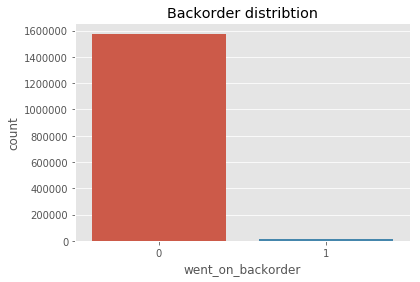

In [5]:
plot = sns.countplot(df.went_on_backorder)
plot.set_title("Backorder distribtion")

# Building model
\#1 Split dataset to train/test

In [6]:
train, test = train_test_split(df, test_size = 0.3, random_state=42)
X_train, y_train = train.drop('went_on_backorder', axis=1), train.went_on_backorder
X_test, y_test= test.drop('went_on_backorder', axis=1), test.went_on_backorder
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1110876, 22), (1110876,), (476091, 22), (476091,))


\#2 Train classifier.

In [8]:
classifier = DecisionTreeClassifier(class_weight='balanced')
# classifier = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_split=10,
#                             max_depth=10, class_weight='balanced')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Model evaluation

Metrics for each class: precision, recall, f1-score and support. 

https://en.wikipedia.org/wiki/Precision_and_recall#Definition_.28classification_context.29

In [10]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    472731
          1       0.35      0.31      0.32      3360

avg / total       0.99      0.99      0.99    476091



Plot ROC curve.

Text(0.5,1,u'AUC : 0.650481028058')

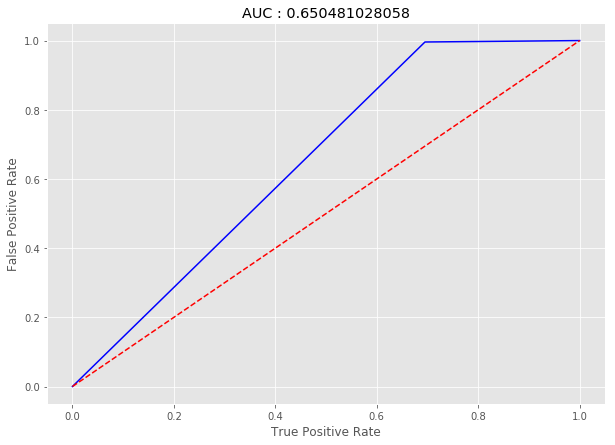

In [11]:
y_pred_proba = classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,0])
auc_score = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(10, 7))
plt.plot(tpr, fpr, 'b-')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('AUC : {}'.format(auc_score))

Which features are the most important for the classifier?

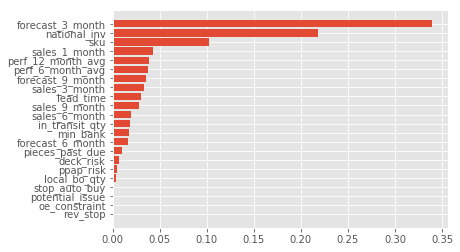

In [12]:
def features_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
features_importances(classifier.feature_importances_, train.drop('went_on_backorder', axis=1))